In [3]:
#reveal configuration
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'theme': 'white',
        'transition': 'none',
        'controls': 'false',
        'progress': 'true',
})

import tensorflow as tf
import numpy as np

%load_ext tikzmagic

In [4]:
%%javascript
require(['base/js/utils'],
function(utils) {
   utils.load_extensions('calico-spell-check', 'calico-document-tools', 'calico-cell-tools');
});

<IPython.core.display.Javascript object>

In [5]:
%%html
<style>
.red { color: #E41A1C; }
.orange { color: #FF7F00 }
.yellow { color: #FFC020 }         
.green { color: #4DAF4A }                  
.blue { color: #377EB8; }
.purple { color: #984EA3 }       
</style>

# Deep Learning for Natural Language Processing

# Outline
- Use-case: Recognizing Textual Entailment
  - Conditional Encoding
  - Attention
- Bag of Tricks
  - Continuous Optimization   
  - Regularization  
  - Hyper-parameter Optimization
  - Pre-trained Representations
  - Batching
  - Bucketing
  - <span class="blue">TensorFlow</span> `dynamic_rnn`  
  - Bi-directional RNNs

# Recognizing Textual Entailment (RTE)

- **A wedding party is taking pictures**
  - There is a funeral					: **<span class=red>Contradiction</span>**
  - They are outside					: **<span class=blue>Neutral</span>**
  - Someone got married				    : **<span class=green>Entailment</span>**

### State of the Art until 2015

[<span class=blue>Lai and Hockenmaier, 2014, Jimenez et al., 2014, Zhao et al., 2014, Beltagy et al., 2015</span> etc.]

- Engineered natural language processing pipelines
- Various external resources
- Specialized subcomponents
- Extensive manual creation of **features**:
  - Negation detection, word overlap, part-of-speech tags, dependency parses, alignment, unaligned matching, chunk alignment, synonym, hypernym, antonym, denotation graph

### Neural Networks for RTE

**Problem**:
- Tiny data sets
- Synthetic examples

**Stanford Natural Inference Corpus**:
- 500'000 sentence pairs
- Two orders of magnitude larger than existing RTE data set
- All examples generated by humans


### Independent Sentence Encoding

[<span class=blue>Bowman et al, 2015</span>]

Same LSTM encodes premise and hypothesis

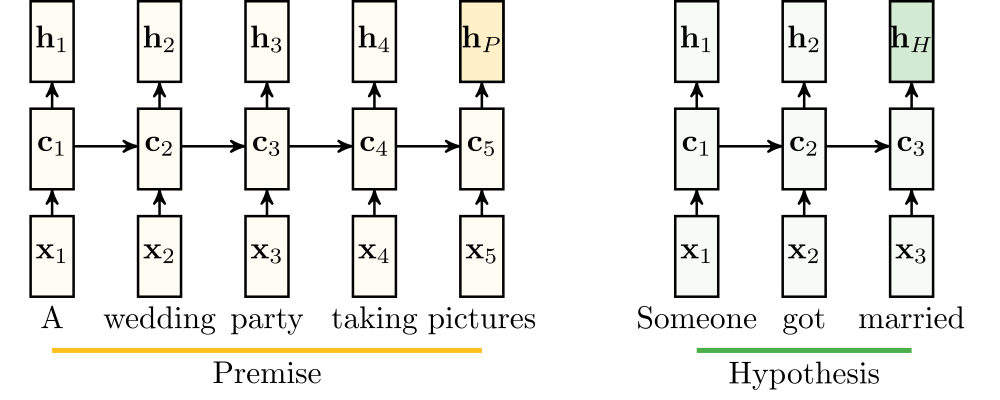

In [286]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}     
\path[draw, thick, fill=nice-yellow!25] (5-0.2,2) rectangle (5+0.2,2.75) {};  
\foreach \i/\l in {7/1,8/2,9/3} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}
\path[draw, thick, fill=nice-green!25] (9-0.2,2) rectangle (9+0.2,2.75) {};        
\foreach \i/\l in {1/1,2/2,3/3,4/4,7/1,8/2} {
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}        
\node[] at (5,2.4) {$\mathbf{h}_P$};
\node[] at (9,2.4) {$\mathbf{h}_H$};        
\foreach \i in {1,2,3,4,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};  

### Independent Sentence Encoding

[<span class=blue>Bowman et al, 2015</span>]

Same LSTM encodes premise and hypothesis

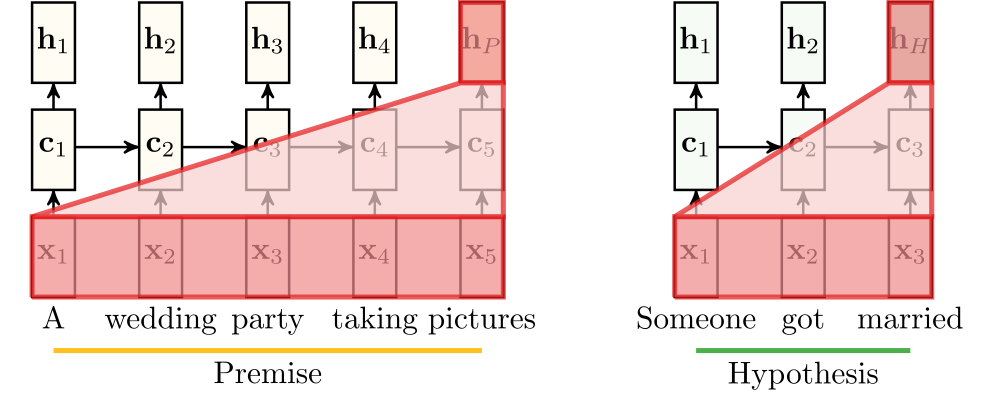

In [287]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}     
\path[draw, thick, fill=nice-yellow!25] (5-0.2,2) rectangle (5+0.2,2.75) {};  
\foreach \i/\l in {7/1,8/2,9/3} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
}
\path[draw, thick, fill=nice-green!25] (9-0.2,2) rectangle (9+0.2,2.75) {};        
\foreach \i/\l in {1/1,2/2,3/3,4/4,7/1,8/2} {
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}        
\node[] at (5,2.4) {$\mathbf{h}_P$};
\node[] at (9,2.4) {$\mathbf{h}_H$};        
\foreach \i in {1,2,3,4,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis}; 

\foreach \s/\e in {0/5,6/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,0.75);       
}                                    

> You can’t cram the meaning of a whole
%&!\$# sentence into a single \$&!#* vector!
>
> -- <cite>Raymond J. Mooney</cite>

### Independent Sentence Encoding

[<span class=blue>Bowman et al, 2015</span>]

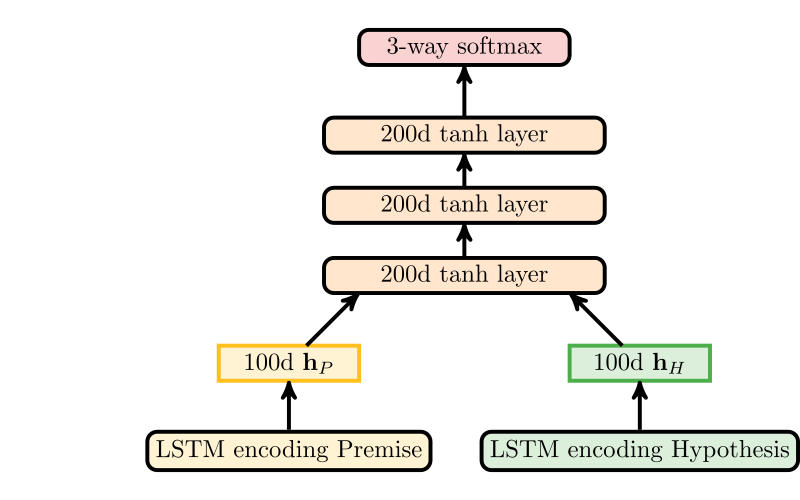

In [288]:
%%tikz -l arrows -s 800,500 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

%lstms
\node[anchor=center, draw, ultra thick, rounded corners, fill=nice-yellow!20] (P) at (0,0) {LSTM encoding Premise};
\node[anchor=center, draw, ultra thick, rounded corners, fill=nice-green!20] (H) at (5,0) {LSTM encoding Hypothesis};
%sentence vectors
\draw[ultra thick, color=nice-yellow, fill=nice-yellow!20] (-1,1) rectangle (1,1.5);
\draw[ultra thick, color=nice-green, fill=nice-green!20] (4,1) rectangle (6,1.5);
%tanh layers
\draw[ultra thick, fill=nice-orange!20, rounded corners] (0.5,2.25) rectangle (4.5,2.75);
\draw[ultra thick, fill=nice-orange!20, rounded corners] (0.5,3.25) rectangle (4.5,3.75);
\draw[ultra thick, fill=nice-orange!20, rounded corners] (0.5,4.25) rectangle (4.5,4.75);
%softmax
\draw[ultra thick, fill=nice-red!20, rounded corners] (1,5.5) rectangle (4,6);

%annotations
\node[] at (0,1.25) {100d $\mathbf{h}_P$};
\node[] at (5,1.25) {100d $\mathbf{h}_H$};
\node[] at (2.5,2.5) {200d tanh layer};
\node[] at (2.5,3.5) {200d tanh layer};
\node[] at (2.5,4.5) {200d tanh layer};
\node[] at (2.5,5.75) {3-way softmax};

%arrows
\draw[->, >=stealth', ultra thick] (P) -- (0,1);
\draw[->, >=stealth', ultra thick] (H) -- (5,1);
\draw[->, >=stealth', ultra thick] (0.25,1.5) -- (1,2.25);
\draw[->, >=stealth', ultra thick] (4.75,1.5) -- (4,2.25);
\draw[->, >=stealth', ultra thick] (2.5,2.75) -- (2.5,3.25);
\draw[->, >=stealth', ultra thick] (2.5,3.75) -- (2.5,4.25);
\draw[->, >=stealth', ultra thick] (2.5,4.75) -- (2.5,5.5);
      
%dummy node for centering
\node[] at (-4,0) {};

#### <span class="blue">TensorFlow</span>: Multi-layer Perceptron

In [289]:
with tf.Graph().as_default():
    def mlp(input_vector, layers=3, hidden_dim=200, output_dim=3):    
        # [input_size] => [input_size x 1] (column vector)
        tmp = tf.expand_dims(input_vector, 1)
        for i in range(layers+1):
            W = tf.get_variable(
                "W_"+str(i), [hidden_dim, hidden_dim])
            # tanh(Wx^T)
            tmp = tf.tanh(tf.matmul(W, tmp))
        W = tf.get_variable(
            "W_"+str(layers+1), [output_dim, hidden_dim])
        # [input_size x 1] => [input_size]
        return tf.squeeze(tf.matmul(W, tmp))
    premise = tf.placeholder(tf.float32, [None], "premise")
    hypothesis = tf.placeholder(tf.float32, [None], "hypothesis")
    output = tf.nn.softmax(mlp(tf.concat(0, [premise, hypothesis])))
    # in practice: outputs of an LSTM
    v1 = np.random.rand(100); v2 = np.random.rand(100)
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(sess.run(output, {premise: v1, hypothesis: v2}))

[ 0.97730732  0.02076106  0.00193162]


| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|

### Conditional Endcoding

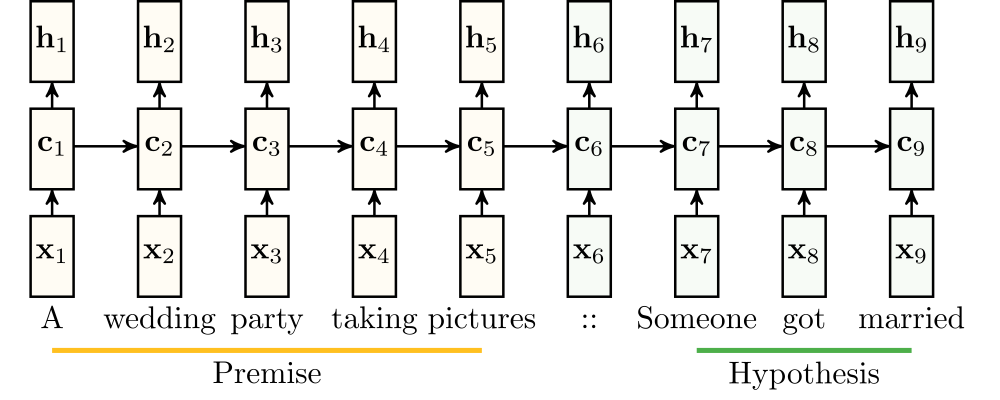

In [290]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};

\begin{align}
\text{softmax}(\text{tanh}(\mathbf{W}\mathbf{h}_N))
\end{align}

### Conditional Endcoding

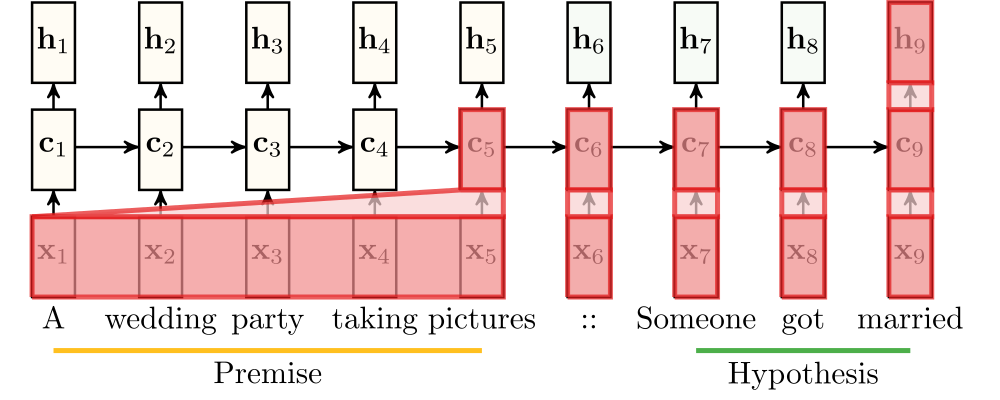

In [291]:
%%tikz -l arrows -sc 1.2 -s 1000,400 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
\foreach \s/\e in {0/5,5/6/,6/7,7/8} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75);       
} 
\foreach \s/\e in {8/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1)
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);                                    
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75)  
        (\s+0.8,1.75) -- (\e+0.2,1.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,1.75);                                       
}          

\begin{align}
\text{softmax}(\text{tanh}(\mathbf{W}\mathbf{h}_N))
\end{align}

## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Endcoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|

### Attention [<span class=blue>Graves 2013</span>, <span class=blue>Bahdanau et al. 2015</span>]


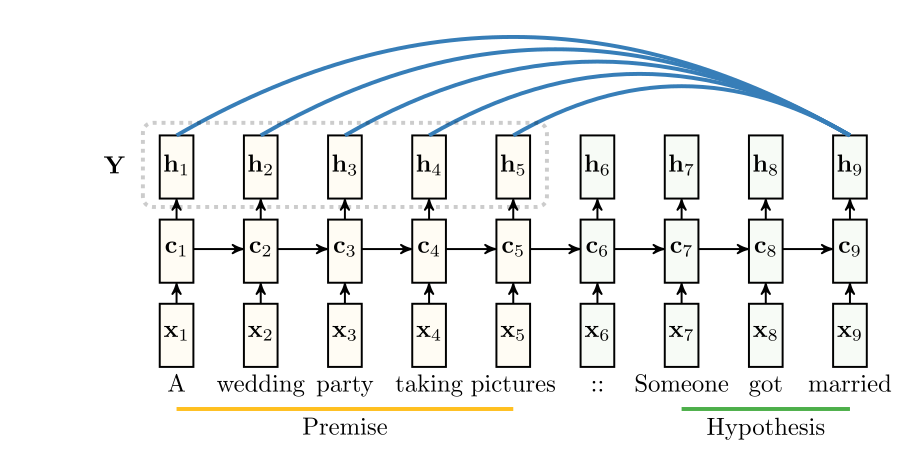

In [292]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {};         

\draw[ultra thick, rounded corners, opacity=0.2, dotted] (0.6,1.9) rectangle (5.4,2.9);  
\node[anchor=east] at (0.5,2.4) {$\mathbf{Y}$};        

<div class=small>
\begin{align}
  \mathbf{M} &= \tanh(\mathbf{W}^y\mathbf{Y}+ \mathbf{W}^h\mathbf{h}_N\mathbf{1}^T_L)&\mathbf{M}&\in\mathbb{R}^{k \times L}\\
  \alpha &= \text{softmax}(\mathbf{w}^T\mathbf{M})&\alpha&\in\mathbb{R}^L\\
  \mathbf{r} &= \mathbf{Y}\alpha^T&\mathbf{r}&\in\mathbb{R}^k
\end{align}
</div>

### Attention [<span class=blue>Graves 2013</span>, <span class=blue>Bahdanau et al. 2015</span>]


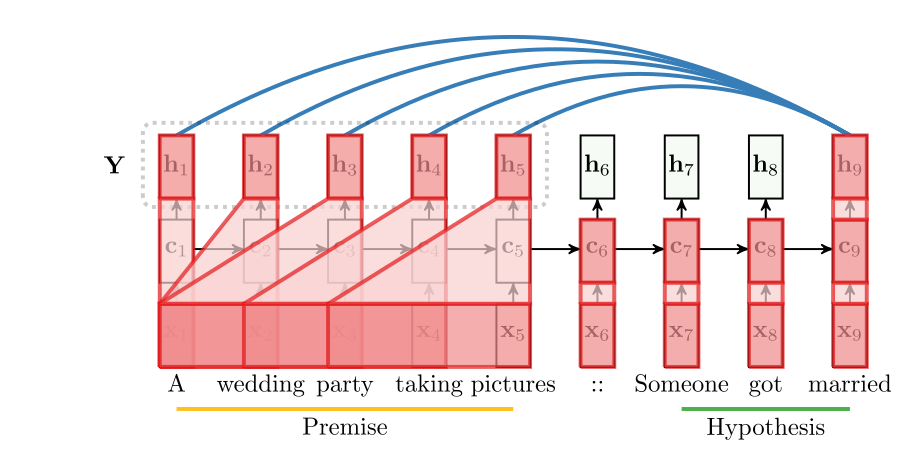

In [293]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {}; 

\draw[ultra thick, rounded corners, opacity=0.2, dotted] (0.6,1.9) rectangle (5.4,2.9);  
\node[anchor=east] at (0.5,2.4) {$\mathbf{Y}$};         
        
\foreach \s/\e in {0/1,0/2,0/3,1/4,2/5} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,0.75);       
}                                            
        
\foreach \s/\e in {5/6/,6/7,7/8} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75);       
} 
\foreach \s/\e in {8/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1)
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);                                    
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75)  
        (\s+0.8,1.75) -- (\e+0.2,1.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,1.75);                                       
}                 

<div class=small>
\begin{align}
  \mathbf{M} &= \tanh(\mathbf{W}^y\mathbf{Y}+ \mathbf{W}^h\mathbf{h}_N\mathbf{1}^T_L)&\mathbf{M}&\in\mathbb{R}^{k \times L}\\
  \alpha &= \text{softmax}(\mathbf{w}^T\mathbf{M})&\alpha&\in\mathbb{R}^L\\
  \mathbf{r} &= \mathbf{Y}\alpha^T&\mathbf{r}&\in\mathbb{R}^k
\end{align}
</div>

<img  src="./dl-applications-figures/camel.png"/>

#### Contextual Understanding

<img  src="./dl-applications-figures/pink.png"/>

## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Encoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|
| Attention | 100 | 3.9M | 242k | 85.4 | 83.2 | 82.3 |

#### Fuzzy Attention

<img  src="./dl-applications-figures/mimes.png"/>

### Word-by-word Attention [<span class=blue>Bahdanau et al. 2015</span>, <span class=blue>Hermann et al. 2015</span>, <span class=blue>Rush et al. 2015</span>]

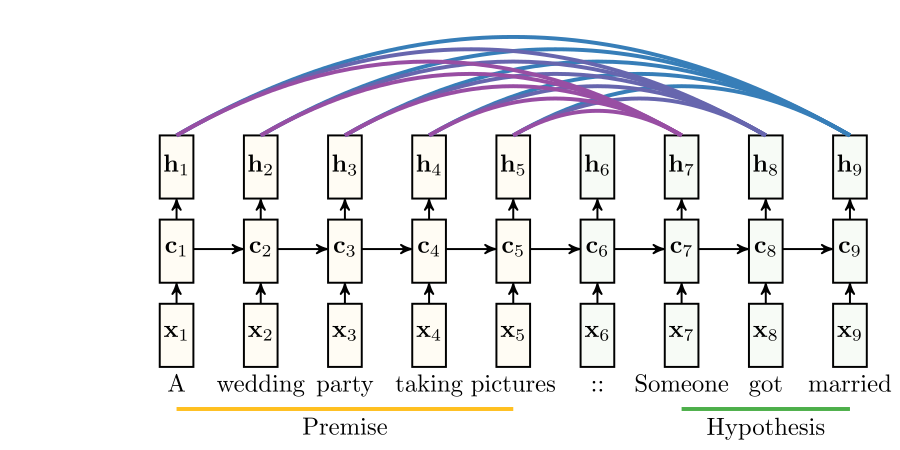

In [294]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue!50!nice-purple] (8,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-purple] (7,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {};

<div class=small>
\begin{align}
  \mathbf{M}_t &= \tanh(\mathbf{W}^y\mathbf{Y}+(\mathbf{W}^h\mathbf{h}_t+\mathbf{W}^r\mathbf{r}_{t-1})\mathbf{1}^T_L) & \mathbf{M}_t &\in\mathbb{R}^{k\times L}\\
  \alpha_t &= \text{softmax}(\mathbf{w}^T\mathbf{M}_t)&\alpha_t&\in\mathbb{R}^L\\
  \mathbf{r}_t &= \mathbf{Y}\alpha^T_t + \tanh(\mathbf{W}^t\mathbf{r}_{t-1})&\mathbf{r}_t&\in\mathbb{R}^k
\end{align}
</div>

### Word-by-word Attention [<span class=blue>Bahdanau et al. 2015</span>, <span class=blue>Hermann et al. 2015</span>, <span class=blue>Rush et al. 2015</span>]

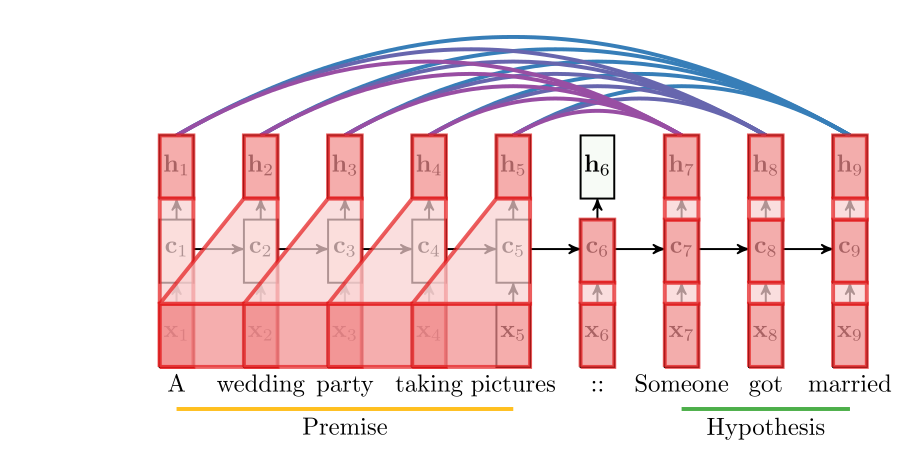

In [295]:
%%tikz -l arrows -sc 1.2 -s 900,450 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3,4/4,5/5} {
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-yellow!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i/\l in {6/6,7/7,8/8,9/9} {
  \path[draw, thick, fill=nice-green!5] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-green!5] (\i-0.2,2) rectangle (\i+0.2,2.75) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i,1.75) -- (\i,2);
  \node[] at (\i,0.4) {$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {$\mathbf{c}_\l$};
  \node[] at (\i,2.4) {$\mathbf{h}_\l$};
}
\foreach \i in {1,2,3,4,5,6,7,8} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
}

\foreach \i/\word in {1/A, 2/wedding, 3/party, 4/taking, 5/pictures, 6/::, 7/Someone, 8/got, 9/married} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex] at (\i,0) {\word};
}
\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue] (9,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-blue!50!nice-purple] (8,2.75) edge [bend right] (\i,2.75);
}

\foreach \i in {1,2,3,4,5} {
  \path[draw, ultra thick, color=nice-purple] (7,2.75) edge [bend right] (\i,2.75);
}

\draw[ultra thick, nice-yellow] (1,-0.5) -- (5,-0.5);
\draw[ultra thick, nice-green] (7,-0.5) -- (9,-0.5);

\node[anchor=north] at (3,-0.5) {Premise};
\node[anchor=north] at (8,-0.5) {Hypothesis};
        
%dummy node for centering
\node[] at (-1,0) {};
        
\foreach \s/\e in {0/1,0/2,1/3,2/4,3/5} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,0.75);       
}                                            
\foreach \s/\e in {6/7,7/8,8/9} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1)
        (\e-0.2,2) -- (\e+0.2,2) -- (\e+0.2,2.75) -- (\e-0.2,2.75) -- (\e-0.2,2);                                    
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75)  
        (\s+0.8,1.75) -- (\e+0.2,1.75) -- (\e+0.2,2) -- (\e-0.2,2) -- (\s+0.8,1.75);                                       
}          
\foreach \s/\e in {5/6} {        
    \draw[ultra thick, color=nice-red, fill=nice-red!50!white, opacity=0.7] 
        (\s+0.8,0) -- (\e+0.2,0) -- (\e+0.2,0.75) -- (\s+0.8,0.75) -- (\s+0.8,0) 
        (\e-0.2,1) -- (\e+0.2,1) -- (\e+0.2,1.75) -- (\e-0.2,1.75) -- (\e-0.2,1);
    \draw[ultra thick, color=nice-red, fill=nice-red!20, opacity=0.7]         
        (\s+0.8,0.75) -- (\e+0.2,0.75) -- (\e+0.2,1) -- (\e-0.2,1) -- (\s+0.8,0.75);  
}         

<div class=small>
\begin{align}
  \mathbf{M}_t &= \tanh(\mathbf{W}^y\mathbf{Y}+(\mathbf{W}^h\mathbf{h}_t+\mathbf{W}^r\mathbf{r}_{t-1})\mathbf{1}^T_L) & \mathbf{M}_t &\in\mathbb{R}^{k\times L}\\
  \alpha_t &= \text{softmax}(\mathbf{w}^T\mathbf{M}_t)&\alpha_t&\in\mathbb{R}^L\\
  \mathbf{r}_t &= \mathbf{Y}\alpha^T_t + \tanh(\mathbf{W}^t\mathbf{r}_{t-1})&\mathbf{r}_t&\in\mathbb{R}^k
\end{align}
</div>

#### Reordering

<img src="./dl-applications-figures/reordering.png" width=60%/>

#### Garbage Can = Trashcan

<img  src="./dl-applications-figures/trashcan.png" width=90%/>

#### Kids =  Girl + Boy

<img  src="./dl-applications-figures/kids.png" width=80%/>

## Snow is outside

<img  src="./dl-applications-figures/snow.png"/>

## Results

| Model | k | θ<sub>W+M</sub> | θ<sub>M</sub> | Train | Dev | Test |
|-|-|-|-|-|-|-|
| LSTM [<span class=blue>Bowman et al.</span>] | 100 | \\(\approx\\)10M | 221k | 84.4 | - | 77.6|
| Classifier [<span class=blue>Bowman et al.</span>]| - | - | - | 99.7 | - | 78.2|
| Conditional Encoding | 159 | 3.9M | 252k | 84.4 | 83.0 | 81.4|
| Attention | 100 | 3.9M | 242k | 85.4 | 83.2 | 82.3 |
| Word-by-word Attention | 100 | 3.9M | 252k | 85.3 | **83.7** | **83.5** |

# Bag of Tricks

## Continuous Optimization

<img  src="https://upload.wikimedia.org/wikipedia/commons/6/68/Gradient_ascent_%28surface%29.png" width=800/>
Source: Wikipedia

### Momentum

<img  src="http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif" width=800/>

#### <span class="blue">TensorFlow</span>: Optimizers

- GradientDescent
- RMSProp
- Adagrad

- Adadelta
- **Adam**

In [296]:
with tf.Graph().as_default():
    x = tf.get_variable("param", [])  
    loss = -tf.log(tf.sigmoid(x))  # dummy example
    optim = tf.train.AdamOptimizer(learning_rate=0.1)
    min_op = optim.minimize(loss)
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sess.run(x.assign(1.5))
        for i in range(10):
            print(sess.run([min_op, loss], {})[1])

0.201413
0.183901
0.167832
0.153134
0.139727
0.127529
0.116455
0.106421
0.0973447
0.0891449


### Gradient Clipping

In [297]:
with tf.Graph().as_default():
    x = tf.get_variable("param", [])      
    loss = -tf.log(tf.sigmoid(x))  # dummy example
    optim = tf.train.AdamOptimizer(learning_rate=0.1)    
    gradients = optim.compute_gradients(loss)
    capped_gradients = \
        [(tf.clip_by_value(grad, -0.1, 0.1), var) for grad, var in gradients]
    min_op = optim.apply_gradients(capped_gradients)        
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables()); sess.run(x.assign(1.5))        
        for i in range(100):
            if i % 10 == 0:
                grads = sess.run([min_op, gradients, capped_gradients], {})[1:]
                print(" => ".join([str(grad[0][0]) for grad in grads]))

-0.182426 => -0.1
-0.167982 => -0.1
-0.154465 => -0.1
-0.141851 => -0.1
-0.130109 => -0.1
-0.119203 => -0.1
-0.109097 => -0.1
-0.0997508 => -0.0997508
-0.0911243 => -0.0911243
-0.0832129 => -0.0832129


## Regularization

### Dropout

<img src="http://everglory99.github.io/Intro_DL_TCC/intro_dl_images/dropout1.png" width=1000></img>

For RNNs: `tf.nn.rnn_cell.DropoutWrapper`

In [22]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, [None], "input")
    x_dropped = tf.nn.dropout(x, 0.7)  # keeps 70% of values
    
    with tf.Session() as sess:        
        print(sess.run(x_dropped, {x: np.random.rand(6)}))

[ 0.19594376  0.55282122  0.05783162  0.          0.54578322  0.        ]


### Early Stopping

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1f/Overfitting_svg.svg" width=800></img>

## Hyper-parameter Optimization
[<span class=blue>Bergstra and Bengio 2012</span>]
<img src="https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png"></img>

## Pre-trained Representations

In [39]:
with tf.Graph().as_default():
    vocab_size = 4; embedding_size = 3
    W = tf.get_variable("W", [vocab_size, embedding_size], trainable=False)
    W = W.assign(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]))
    seq =  tf.placeholder(tf.int64, [None], "seq")
    seq_embedded = tf.nn.embedding_lookup(W, seq)
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(sess.run(seq_embedded, {seq:[0, 3, 2, 3, 1]})[2])

[ 6.  7.  8.]


### Projecting Representations

In [38]:
with tf.Graph().as_default():
    vocab_size = 4; embedding_size = 3; input_size = 2
    W = tf.get_variable("W", [vocab_size, embedding_size], trainable=False)
    W = W.assign(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]))
    seq =  tf.placeholder(tf.int64, [None], "seq")
    seq_embedded = tf.contrib.layers.linear(tf.nn.embedding_lookup(W, seq), input_size)
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(sess.run(seq_embedded, {seq:[0, 3, 2, 3, 1]})[2])

[ -4.09411907 -14.17657852]


## Batching
- Utilization of GPUs

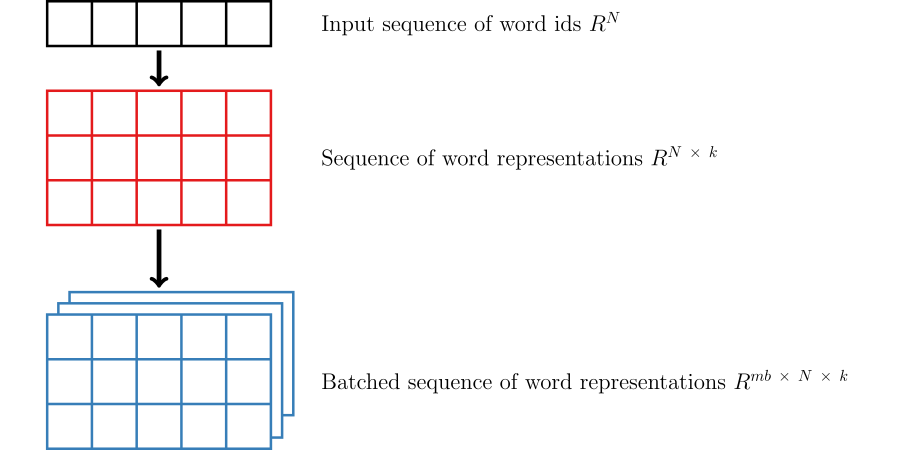

In [309]:
%%tikz -l arrows -sc 1.0 -s 900,450 -f svg
\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\draw[ultra thick] (0,0) rectangle (5,1) (0,0) grid (5,1);
\node[anchor=west] at (6,0.5) {\Large Input sequence of word ids $R^N$};

\draw[line width=3pt, ->] (2.5, -0.1) -- (2.5, -0.9);

\draw[ultra thick, nice-red] (0,-4) rectangle (5,-1) (0,-4) grid (5,-1);
\node[anchor=west] at (6,-2.5) {\Large Sequence of word representations $R^{N\ \times\ k}$};

\draw[line width=3pt, ->] (2.5, -4.1) -- (2.5, -5.4);

\draw[ultra thick, nice-blue, fill=white] (0.5,-8.25) rectangle (5.5,-5.5);
\draw[ultra thick, nice-blue, fill=white] (0.25,-8.75) rectangle (5.25,-5.75);
\draw[ultra thick, nice-blue, fill=white] (0,-9) rectangle (5,-6) (0,-9) grid (5,-6);
\node[anchor=west] at (6,-7.5) {\Large Batched sequence of word representations $R^{mb\ \times\ N\ \times\ k}$};


## Bucketing
- Increased computational efficiency by grouping data into buckets of similar length

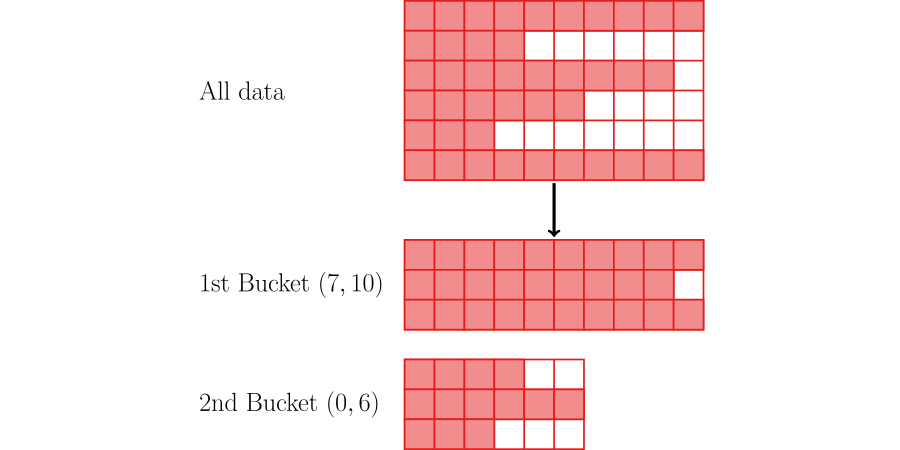

In [355]:
%%tikz -l arrows -sc 1.0 -s 900,450 -f svg
\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\draw[ultra thick, nice-red] (0,0) rectangle (10,-6) (0,0) grid (10,-6);

\foreach \i/\l in {0/9,1/3,2/8,3/5,4/2,5/9} {        
    \foreach \j in {0,...,\l} {
        \draw[ultra thick, nice-red, fill=nice-red!50] (\j,-\i) rectangle (\j+1,-\i-1);
    }
}

\draw[line width=3pt, ->] (5,-6.1) -- (5,-7.9);

\draw[ultra thick, nice-red] (0,-8) rectangle (10,-11) (0,-8) grid (10,-11);

\foreach \i/\l in {0/9,1/8,2/9} {        
    \foreach \j in {0,...,\l} {
        \draw[ultra thick, nice-red, fill=nice-red!50] (\j,-\i-8) rectangle (\j+1,-\i-9);
    }
}

\draw[ultra thick, nice-red] (0,-12) rectangle (6,-15) (0,-12) grid (6,-15);

\foreach \i/\l in {0/3,1/5,2/2} {        
    \foreach \j in {0,...,\l} {
        \draw[ultra thick, nice-red, fill=nice-red!50] (\j,-\i-12) rectangle (\j+1,-\i-13);
    }
}
       
\node[anchor = west] at (-7,-3) {\Huge All data};
\node[anchor = west] at (-7,-9.5) {\Huge 1st Bucket $(7,10)$};
\node[anchor = west] at (-7,-13.5) {\Huge 2nd Bucket $(0,6)$};




## <span class="blue">TensorFlow</span>: `dynamic_rnn`
- Avoids padding (which can hurt performance)

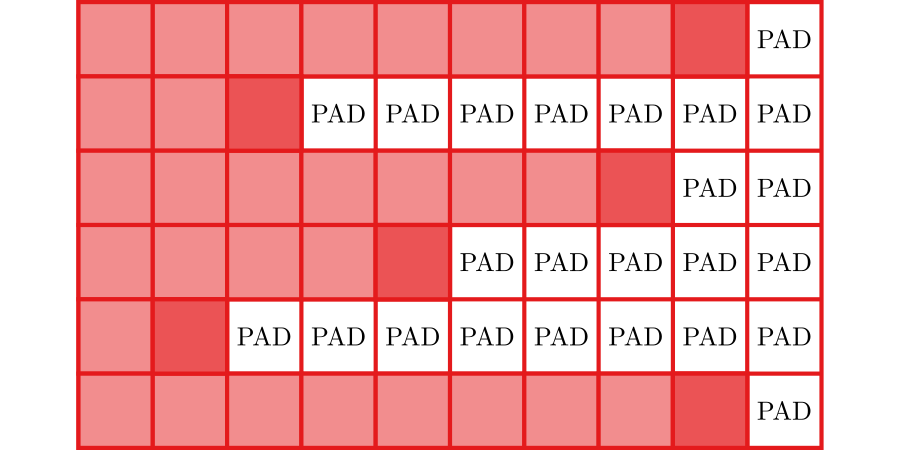

In [66]:
%%tikz -l arrows -sc 1.0 -s 900,450 -f svg
\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\draw[ultra thick, nice-red] (0,0) rectangle (10,-6) (0,0) grid (10,-6);

\foreach \i/\l in {0/8,1/2,2/7,3/4,4/1,5/8} {        
    \foreach \j in {0,...,\l} {
        \draw[ultra thick, nice-red, fill=nice-red!50] (\j,-\i) rectangle (\j+1,-\i-1);
    }
}

\foreach \i/\l in {0/9,1/3,2/8,3/5,4/2,5/9} {        
    \draw[ultra thick, nice-red, fill=nice-red!75] (\l-1,-\i) rectangle (\l,-\i-1);
    \foreach \j in {\l,...,9} {
        \node[] at (\j+0.5,-\i-0.5) {PAD};
    }
}

In [41]:
with tf.Graph().as_default():
    input_size = 2; output_size = 3; batch_size = 5; max_length = 7
    cell = tf.nn.rnn_cell.LSTMCell(output_size)
    input_embedded = tf.placeholder(tf.float32, [None, None, input_size], "input_embedded")
    input_length = tf.placeholder(tf.int64, [None], "input_length")
    outputs, states = \
        tf.nn.dynamic_rnn(cell, input_embedded, sequence_length=input_length, dtype=tf.float32)    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(sess.run(states, {
                    input_embedded: np.random.randn(batch_size, max_length, input_size), 
                    input_length: np.random.randint(1, max_length, batch_size)
                }).h)

[[-0.07828863  0.07784089 -0.00747216]
 [-0.038492    0.03572574 -0.03601231]
 [-0.03372879 -0.09718083  0.03966172]
 [-0.18546213  0.10253921 -0.0991728 ]
 [ 0.06936012 -0.20678709 -0.01240843]]


## Bi-directional RNNs

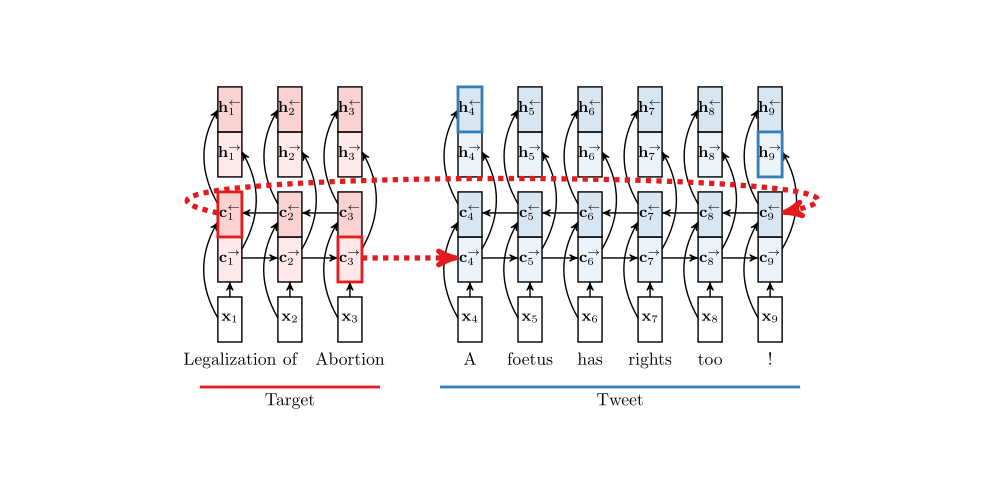

In [300]:
%%tikz -l arrows -sc 1.2 -s 1000,500 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\foreach \i/\l in {1/1,2/2,3/3} {
  \path[draw, thick] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-red!10] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-red!20] (\i-0.2,1.75) rectangle (\i+0.2,2.5) {};  
  \path[draw, thick, fill=nice-red!10] (\i-0.2,2.75) rectangle (\i+0.2,3.5) {};
  \path[draw, thick, fill=nice-red!20] (\i-0.2,3.5) rectangle (\i+0.2,4.25) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i-0.2,0.4) to[bend left=30] (\i-0.2,2);
  \draw[->, >=stealth', thick] (\i-0.2,2.3) to[bend left=30] (\i-0.2,3.87);
  \draw[->, >=stealth', thick] (\i+0.2,1.55) to[bend right=30] (\i+0.2,3.17);  
  \node[] at (\i,0.4) {\small$\mathbf{x}_\l$};
  \node[] at (\i,1.4) {\small$\mathbf{c}^\rightarrow_\l$};
  \node[] at (\i,2.15) {\small$\mathbf{c}^\leftarrow_\l$};
  \node[] at (\i,3.15) {\small$\mathbf{h}^\rightarrow_\l$};
  \node[] at (\i,3.9) {\small$\mathbf{h}^\leftarrow_\l$};
}
\foreach \i/\l in {5/4,6/5,7/6,8/7,9/8,10/9} {
  \path[draw, thick] (\i-0.2,0) rectangle (\i+0.2,0.75) {};
  \path[draw, thick, fill=nice-blue!10] (\i-0.2,1) rectangle (\i+0.2,1.75) {};
  \path[draw, thick, fill=nice-blue!20] (\i-0.2,1.75) rectangle (\i+0.2,2.5) {};  
  \path[draw, thick, fill=nice-blue!10] (\i-0.2,2.75) rectangle (\i+0.2,3.5) {};
  \path[draw, thick, fill=nice-blue!20] (\i-0.2,3.5) rectangle (\i+0.2,4.25) {};
  \draw[->, >=stealth', thick] (\i,0.75) -- (\i,1);
  \draw[->, >=stealth', thick] (\i-0.2,0.4) to[bend left=30] (\i-0.2,2);
  \draw[->, >=stealth', thick] (\i-0.2,2.3) to[bend left=30] (\i-0.2,3.87);
  \draw[->, >=stealth', thick] (\i+0.2,1.55) to[bend right=30] (\i+0.2,3.17);  
  \node[] at (\i,0.4) {\small$\mathbf{x}_{\l}$};
  \node[] at (\i,1.4) {\small$\mathbf{c}^\rightarrow_{\l}$};
  \node[] at (\i,2.15) {\small$\mathbf{c}^\leftarrow_{\l}$};
  \node[] at (\i,3.15) {\small$\mathbf{h}^\rightarrow_{\l}$};
  \node[] at (\i,3.9) {\small$\mathbf{h}^\leftarrow_{\l}$};
}
\foreach \i in {1,2,5,6,7,8,9} {
  \draw[->, >=stealth', thick] (\i+0.2,1.4) -- (\i+1-0.2,1.4);
  \draw[->, >=stealth', thick] (\i+1-0.2,2.15) -- (\i+0.2,2.15);
}
\foreach \i/\word in {1/Legalization, 2/of, 3/Abortion, 5/A, 6/foetus, 7/has, 8/rights, 9/too, 10/!} {
  \node[anchor=north, text height=1.5ex, text depth=.25ex, yshift=-2em] at (\i, 0.5) {\word};
  %\node[anchor=north, text height=1.5ex, text depth=.25ex, yshift=-2em] at (\i, {Mod(\i,2)*0.5}) {\word};
  %\draw[->] (\i, {Mod(\i,2)*0.5-0.7}) -- (\i,0);
}

\draw[ultra thick, nice-red] (0.5,-0.75) -- (3.5,-0.75);
\draw[ultra thick, nice-blue] (4.5,-0.75) -- (10.5,-0.75);
\node[anchor=north] at (2,-0.75) {Target};
\node[anchor=north] at (7.5,-0.75) {Tweet};
\draw[->, >=stealth', line width=3pt, color=nice-red, dashed] (3+0.2,1.4) -- (4+1-0.2,1.4);
\draw[->, >=stealth', line width=3pt, color=nice-red, dashed] (1-0.2,2.15) to[bend left=168] (10+0.2,2.15);

\path[draw, ultra thick, color=nice-blue] (5-0.2,3.5) rectangle (5+0.2,4.25) {};
\path[draw, ultra thick, color=nice-blue] (10-0.2,2.75) rectangle (10+0.2,3.5) {};
\path[draw, ultra thick, color=nice-red] (1-0.2,1.75) rectangle (1+0.2,2.5) {};  
\path[draw, ultra thick, color=nice-red] (3-0.2,1) rectangle (3+0.2,1.75) {};

# Background Material

- [A Primer on Neural Network Models for Natural Language Processing](http://www.jair.org/media/4992/live-4992-9623-jair.pdf)
- [Stanford Course: Deep Learning for Natural Language Processing](http://cs224d.stanford.edu/syllabus.html)
- [Nando de Freitas' Deep Learning Lecture](https://www.youtube.com/watch?v=dV80NAlEins&list=PLE6Wd9FR--EfW8dtjAuPoTuPcqmOV53Fu)